In [52]:
!pip install tqdm



  Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)



[notice] A new release of pip available: 22.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [53]:
import os
import cv2
import numpy as np
from PIL import Image
from scipy.stats import entropy
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
from tensorflow.keras.models import Model
from tqdm import tqdm

# ------------ Config ------------
DATASET_DIR = "sdc"
THRESH_BLUR = 100             # Laplacian variance threshold (blurriness)
THRESH_ENTROPY = 2.0          # Entropy threshold (uninformative)
THRESH_VEC_NORM = 10.0        # Feature vector norm (low context)
# --------------------------------

# Load EfficientNet for embedding extraction
base_model = EfficientNetB0(include_top=False, pooling='avg')
model = Model(inputs=base_model.input, outputs=base_model.output)

def is_blurry(img_path, threshold=THRESH_BLUR):
    img = cv2.imread(img_path)
    if img is None:
        return True
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return cv2.Laplacian(gray, cv2.CV_64F).var() < threshold

def is_low_entropy(img_path, threshold=THRESH_ENTROPY):
    try:
        img = Image.open(img_path).convert('L')
        hist = np.array(img.histogram())
        hist = hist / hist.sum()
        return entropy(hist) < threshold
    except:
        return True

def is_low_feature_vector(img_path, threshold=THRESH_VEC_NORM):
    try:
        img = image.load_img(img_path, target_size=(224, 224))
        x = preprocess_input(np.expand_dims(image.img_to_array(img), axis=0))
        vec = model.predict(x, verbose=0)[0]
        return np.linalg.norm(vec) < threshold
    except:
        return True

def clean_folder(folder_path):
    print(f"\n🧹 Cleaning: {folder_path}")
    total_removed = 0
    for cls in os.listdir(folder_path):
        cls_path = os.path.join(folder_path, cls)
        if not os.path.isdir(cls_path): continue

        for fname in tqdm(os.listdir(cls_path), desc=f"Class: {cls}"):
            img_path = os.path.join(cls_path, fname)

            if (
                is_blurry(img_path) or
                is_low_entropy(img_path) or
                is_low_feature_vector(img_path)
            ):
                os.remove(img_path)
                total_removed += 1

    print(f"✅ Done. Total removed: {total_removed}")

# Run cleaning on train and test folders
clean_folder(os.path.join(DATASET_DIR, "train"))
clean_folder(os.path.join(DATASET_DIR, "test"))



🧹 Cleaning: sdc\train


Class: Acne and Rosacea Photos: 100%|██████████| 1400/1400 [01:09<00:00, 20.15it/s]
Class: Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions: 100%|██████████| 1400/1400 [01:14<00:00, 18.87it/s]
Class: Bullous Disease Photos: 100%|██████████| 1400/1400 [01:03<00:00, 21.96it/s]
Class: Cellulitis Impetigo and other Bacterial Infections: 100%|██████████| 1400/1400 [01:00<00:00, 23.10it/s]
Class: Exanthems and Drug Eruptions: 100%|██████████| 1400/1400 [01:01<00:00, 22.70it/s]
Class: Hair Loss Photos Alopecia and other Hair Diseases: 100%|██████████| 1400/1400 [01:02<00:00, 22.29it/s]
Class: Herpes HPV and other STDs Photos: 100%|██████████| 1400/1400 [01:03<00:00, 22.12it/s]
Class: Light Diseases and Disorders of Pigmentation: 100%|██████████| 1400/1400 [01:04<00:00, 21.67it/s]
Class: Lupus and other Connective Tissue diseases: 100%|██████████| 1400/1400 [01:02<00:00, 22.36it/s]
Class: Nail Fungus and other Nail Disease: 100%|██████████| 1400/1400 [01:10<00:00, 19.75it/s]


✅ Done. Total removed: 32200

🧹 Cleaning: sdc\test


Class: Acne and Rosacea Photos: 100%|██████████| 312/312 [00:18<00:00, 17.13it/s]
Class: Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions: 100%|██████████| 288/288 [00:17<00:00, 16.30it/s]
Class: Bullous Disease Photos: 100%|██████████| 113/113 [00:06<00:00, 16.90it/s]
Class: Cellulitis Impetigo and other Bacterial Infections: 100%|██████████| 73/73 [00:04<00:00, 17.21it/s]
Class: Exanthems and Drug Eruptions: 100%|██████████| 101/101 [00:06<00:00, 16.68it/s]
Class: Hair Loss Photos Alopecia and other Hair Diseases: 100%|██████████| 60/60 [00:03<00:00, 16.51it/s]
Class: Herpes HPV and other STDs Photos: 100%|██████████| 102/102 [00:07<00:00, 13.36it/s]
Class: Light Diseases and Disorders of Pigmentation: 100%|██████████| 143/143 [00:10<00:00, 14.02it/s]
Class: Lupus and other Connective Tissue diseases: 100%|██████████| 105/105 [00:07<00:00, 13.24it/s]
Class: Nail Fungus and other Nail Disease: 100%|██████████| 261/261 [00:15<00:00, 16.90it/s]
Class: Poison Ivy Photos

✅ Done. Total removed: 4002


In [41]:
import os
import shutil
from PIL import Image

# Source and target directories
SOURCE_DIR = 'dataset'
TARGET_DIR = 'dataset'
IMG_SIZE = (1920, 1080)

# Ensure target directories exist
for subset in ['train', 'val']:
    for class_name in os.listdir(os.path.join(SOURCE_DIR, subset)):
        os.makedirs(os.path.join(TARGET_DIR, subset, class_name), exist_ok=True)

# Function to copy & resize images
def process_images(subset):
    print(f"Processing {subset}...")
    src_path = os.path.join(SOURCE_DIR, subset)
    tgt_path = os.path.join(TARGET_DIR, subset)

    for class_name in os.listdir(src_path):
        class_src = os.path.join(src_path, class_name)
        class_tgt = os.path.join(tgt_path, class_name)

        images = os.listdir(class_src)
        for img_name in images:
            try:
                img_src_path = os.path.join(class_src, img_name)
                img_tgt_path = os.path.join(class_tgt, img_name)

                img = Image.open(img_src_path).convert('RGB')
                img = img.resize(IMG_SIZE)
                img.save(img_tgt_path)
            except Exception as e:
                print(f"Error with {img_name}: {e}")

# Run for both subsets
process_images('train')
process_images('val')

print("✅ Done. Resized ALL images per class to 1920x1080 and saved in 'temp' directory.")


Processing train...
Processing val...
✅ Done. Resized ALL images per class to 1920x1080 and saved in 'temp' directory.


In [42]:
import os
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img

# Working Directory
DATASET_DIR = 'dataset'
IMG_SIZE = (1920, 1080)

# Create augmentor once
augmentor = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=10,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

def augment_each_image_once(subset):
    print(f"\n🔄 Augmenting each image in: {subset}")
    subset_path = os.path.join(DATASET_DIR, subset)

    for class_name in os.listdir(subset_path):
        class_dir = os.path.join(subset_path, class_name)
        if not os.path.isdir(class_dir):
            continue

        images = [img for img in os.listdir(class_dir) if img.lower().endswith(('.jpg', '.jpeg', '.png'))]
        print(f"📁 Class: {class_name} - {len(images)} original images")

        for idx, img_name in enumerate(images):
            try:
                img_path = os.path.join(class_dir, img_name)
                img = load_img(img_path).resize(IMG_SIZE)
                x = img_to_array(img)
                x = np.expand_dims(x, axis=0)

                # Generate 1 augmented version
                for batch in augmentor.flow(x, batch_size=1):
                    aug_img = array_to_img(batch[0]).resize(IMG_SIZE)
                    aug_name = f"aug_{idx}_{img_name}"
                    aug_img.save(os.path.join(class_dir, aug_name))
                    break  # Only 1 augmented image per original
            except Exception as e:
                print(f"❌ Failed on {img_name}: {e}")

# Apply to both subsets
augment_each_image_once('train')
augment_each_image_once('val')

print("\n✅ Done. 1 augmented image per original (Full HD) saved in 'temp/train' and 'temp/test'.")



🔄 Augmenting each image in: train
📁 Class: Actinic keratosis - 80 original images
📁 Class: Atopic Dermatitis - 81 original images
📁 Class: Benign keratosis - 80 original images
📁 Class: Dermatofibroma - 80 original images
📁 Class: Melanocytic nevus - 80 original images
📁 Class: Melanoma - 80 original images
📁 Class: Squamous cell carcinoma - 80 original images
📁 Class: Tinea Ringworm Candidiasis - 56 original images
❌ Failed on aug_0_natural-treatment-Daad-khaj-khujli-ringworm-home-treatment-home-remedies-fungal-infection-treatment-symptom-pictures-diagnosis-hindi-gimtrend.blogspot.com.jpeg: [Errno 2] No such file or directory: 'dataset\\train\\Tinea Ringworm Candidiasis\\aug_27_aug_0_natural-treatment-Daad-khaj-khujli-ringworm-home-treatment-home-remedies-fungal-infection-treatment-symptom-pictures-diagnosis-hindi-gimtrend.blogspot.com.jpeg'
📁 Class: Vascular lesion - 80 original images

🔄 Augmenting each image in: val
📁 Class: Actinic keratosis - 20 original images
📁 Class: Atopic D

Loaded 690 images from sdc\train | Skipped 0 non-image files.
Sample labels (first 5): [0, 0, 0, 0, 0] - Types: [<class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>]
Loaded 690 images from sdc\test | Skipped 0 non-image files.
Sample labels (first 5): [0, 0, 0, 0, 0] - Types: [<class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>]
train_labels_flat content (first 5): [14 14  9  1  4]
train_labels_flat types (first 5): [<class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>]
Validation set size: 69


d:\Burhan Bajwa\DermNet-Skin-Disease-Classifier\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Burhan Bajwa\DermNet-Skin-Disease-Classifier\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training started...
Epoch 1/20, Loss: 3.1890, Val Accuracy: 0.0290
Epoch 2/20, Loss: 3.1401, Val Accuracy: 0.0290
Epoch 3/20, Loss: 3.1363, Val Accuracy: 0.0435
Epoch 4/20, Loss: 3.0892, Val Accuracy: 0.1449
Epoch 5/20, Loss: 3.0193, Val Accuracy: 0.1014
Epoch 6/20, Loss: 2.9281, Val Accuracy: 0.3188
Epoch 7/20, Loss: 2.7284, Val Accuracy: 0.4493
Epoch 8/20, Loss: 2.3915, Val Accuracy: 0.5942
Epoch 9/20, Loss: 1.9715, Val Accuracy: 0.7826
Epoch 10/20, Loss: 1.5867, Val Accuracy: 0.6812
Epoch 11/20, Loss: 1.2831, Val Accuracy: 0.7971
Epoch 12/20, Loss: 1.0450, Val Accuracy: 0.8116
Epoch 13/20, Loss: 0.9066, Val Accuracy: 0.8551
Epoch 14/20, Loss: 0.8023, Val Accuracy: 0.9130
Epoch 15/20, Loss: 0.7336, Val Accuracy: 0.9275
Epoch 16/20, Loss: 0.6746, Val Accuracy: 0.9275
Epoch 17/20, Loss: 0.6133, Val Accuracy: 0.9130
Epoch 18/20, Loss: 0.5737, Val Accuracy: 0.8986
Epoch 19/20, Loss: 0.5498, Val Accuracy: 0.9275
Epoch 20/20, Loss: 0.5165, Val Accuracy: 0.9420
Evaluating...

Classification

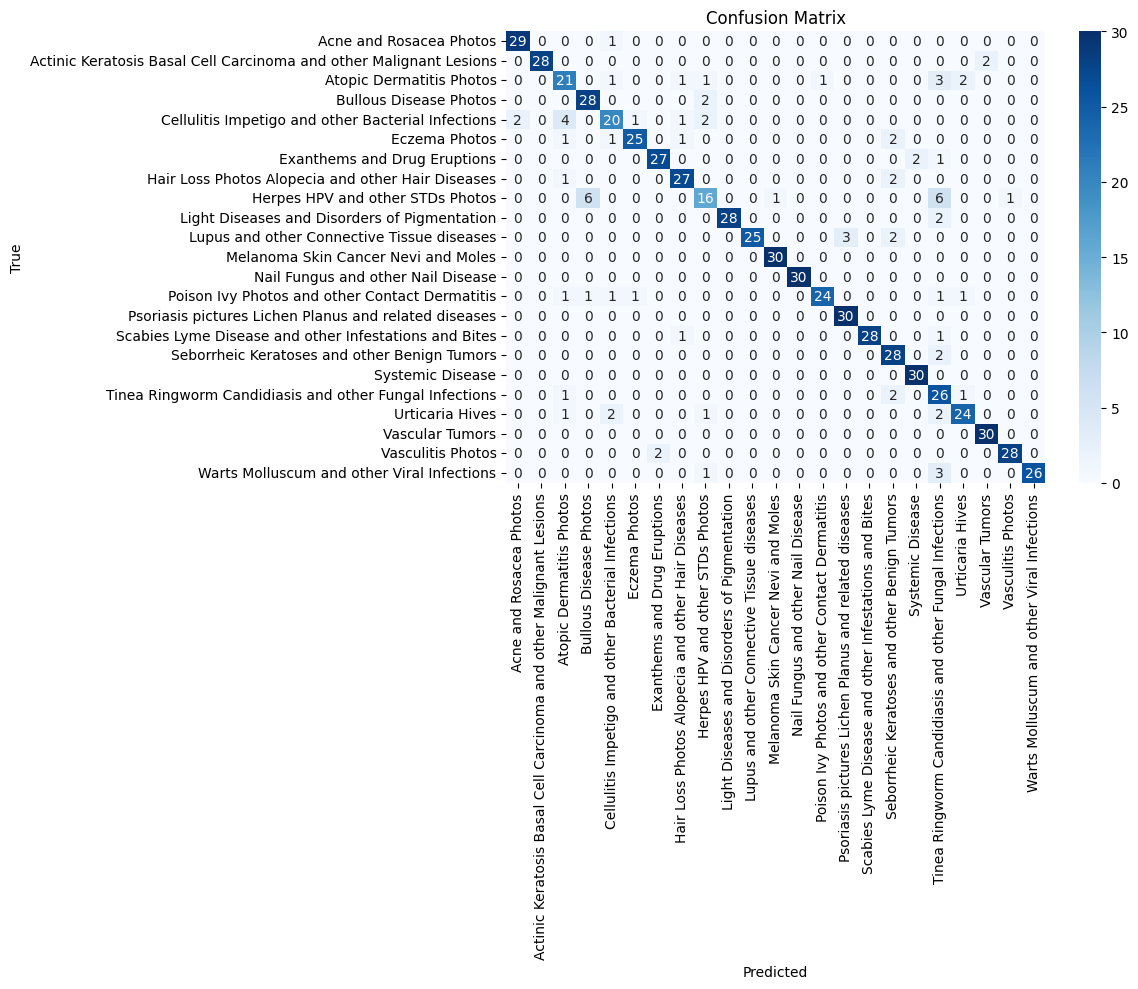


Additional Metrics:
F1 Score: 0.8820
Precision: 0.8910
Recall: 0.8812


In [14]:
import os
import random
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, f1_score, precision_score, recall_score
from sklearn.utils.class_weight import compute_class_weight
from random import randint, sample

# --- Paths ---
BASE_DIR = 'sdc'  # Your dataset path
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
TEST_DIR = os.path.join(BASE_DIR, 'test')
OUTPUT_DIR = 'output'  # For saving models

# --- Parameters ---
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20
NUM_CLASSES = 23
IMAGES_PER_CLASS = 30  # Select exactly 20 images per class
VALIDATION_SPLIT = 0.1  # Split train into 90% train, 10% validation

# --- Device Configuration ---
device = torch.device("cpu")  # CPU-only setup

# --- Disease and Symptom Definitions ---
disease_to_index = {
    "Acne and Rosacea Photos": 0,
    "Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions": 1,
    "Atopic Dermatitis Photos": 2,
    "Bullous Disease Photos": 3,
    "Cellulitis Impetigo and other Bacterial Infections": 4,
    "Eczema Photos": 5,
    "Exanthems and Drug Eruptions": 6,
    "Hair Loss Photos Alopecia and other Hair Diseases": 7,
    "Herpes HPV and other STDs Photos": 8,
    "Light Diseases and Disorders of Pigmentation": 9,
    "Lupus and other Connective Tissue diseases": 10,
    "Melanoma Skin Cancer Nevi and Moles": 11,
    "Nail Fungus and other Nail Disease": 12,
    "Poison Ivy Photos and other Contact Dermatitis": 13,
    "Psoriasis pictures Lichen Planus and related diseases": 14,
    "Scabies Lyme Disease and other Infestations and Bites": 15,
    "Seborrheic Keratoses and other Benign Tumors": 16,
    "Systemic Disease": 17,
    "Tinea Ringworm Candidiasis and other Fungal Infections": 18,
    "Urticaria Hives": 19,
    "Vascular Tumors": 20,
    "Vasculitis Photos": 21,
    "Warts Molluscum and other Viral Infections": 22
}

disease_symptoms = {
    "Acne and Rosacea Photos": ["pimples", "redness", "pustules", "facial_flushing", "papules"],
    "Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions": ["scaly_patches", "pearly_nodule", "ulceration", "bleeding", "telangiectasia"],
    "Atopic Dermatitis Photos": ["itching", "redness", "dry_skin", "crusting", "swelling"],
    "Bullous Disease Photos": ["blisters", "erosions", "itching", "painful_lesions", "fluid_filled"],
    "Cellulitis Impetigo and other Bacterial Infections": ["redness", "swelling", "warmth", "pain", "pustules"],
    "Eczema Photos": ["redness", "itching", "dryness", "scaling", "swelling"],
    "Exanthems and Drug Eruptions": ["rash", "red_spots", "itching", "widespread_lesions", "fever"],
    "Hair Loss Photos Alopecia and other Hair Diseases": ["hair_thinning", "bald_patches", "scalp_itching", "scaling", "redness"],
    "Herpes HPV and other STDs Photos": ["blisters", "ulcers", "pain", "itching", "crusting"],
    "Light Diseases and Disorders of Pigmentation": ["hypopigmentation", "hyperpigmentation", "flat_spots", "itching", "sun_sensitivity"],
    "Lupus and other Connective Tissue diseases": ["butterfly_rash", "joint_pain", "photosensitivity", "red_patches", "scaling"],
    "Melanoma Skin Cancer Nevi and Moles": ["asymmetry", "irregular_border", "color_variation", "diameter", "evolving"],
    "Nail Fungus and other Nail Disease": ["nail_thickening", "discoloration", "brittle_nails", "deformity", "pain"],
    "Poison Ivy Photos and other Contact Dermatitis": ["redness", "itching", "blisters", "swelling", "linear_rash"],
    "Psoriasis pictures Lichen Planus and related diseases": ["red_patches", "silvery_scales", "itching", "plaques", "joint_pain"],
    "Scabies Lyme Disease and other Infestations and Bites": ["itching", "red_bumps", "burrows", "rash", "bullseye_rash"],
    "Seborrheic Keratoses and other Benign Tumors": ["waxy_growth", "brown_black_color", "stuck_on_appearance", "itching", "scaling"],
    "Systemic Disease": ["rash", "fatigue", "fever", "joint_pain", "organ_involvement"],
    "Tinea Ringworm Candidiasis and other Fungal Infections": ["ring_shaped_rash", "itching", "scaling", "redness", "crusting"],
    "Urticaria Hives": ["wheals", "itching", "redness", "swelling", "transient_lesions"],
    "Vascular Tumors": ["red_nodules", "growth", "bleeding", "painless", "vascular_markings"],
    "Vasculitis Photos": ["purpura", "red_spots", "painful_nodules", "ulcers", "joint_pain"],
    "Warts Molluscum and other Viral Infections": ["small_bumps", "painless_nodules", "itching", "rough_surface", "clustered_lesions"]
}

all_possible_symptoms = list(set(sum(disease_symptoms.values(), [])))
symptom_to_index = {sym: idx for idx, sym in enumerate(all_possible_symptoms)}
num_symptoms = len(all_possible_symptoms)

# --- Load Image Paths with Limit of 20 Images per Class ---
def load_images_from_split(split_dir, split_name):
    images, labels = [], []
    non_image_files = 0
    for disease in os.listdir(split_dir):
        disease_dir = os.path.join(split_dir, disease)
        if os.path.isdir(disease_dir) and disease in disease_to_index:
            class_images = [
                os.path.join(disease_dir, img_file)
                for img_file in os.listdir(disease_dir)
                if img_file.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".webp"))
            ]
            if len(class_images) < IMAGES_PER_CLASS:
                print(f"Warning: {disease} in {split_name} has only {len(class_images)} images, using all available.")
            selected_images = random.sample(class_images, min(len(class_images), IMAGES_PER_CLASS))
            images.extend(selected_images)
            labels.extend([disease_to_index[disease]] * len(selected_images))
            non_image_files += len([f for f in os.listdir(disease_dir) if not f.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".webp"))])
    print(f"Loaded {len(images)} images from {split_dir} | Skipped {non_image_files} non-image files.")
    print(f"Sample labels (first 5): {labels[:5]} - Types: {[type(l) for l in labels[:5]]}")
    return images, labels

# --- Symptom Encoding ---
def generate_symptom_array(label_index):
    disease_name = list(disease_to_index.keys())[label_index]
    symptoms = disease_symptoms[disease_name]
    return sample(symptoms, randint(1, len(symptoms)))

def encode_symptoms(symptom_list):
    encoding = np.zeros(num_symptoms)
    for sym in symptom_list:
        encoding[symptom_to_index[sym]] = 1
    return encoding

# --- Custom Dataset ---
class SkinDiseaseDataset(Dataset):
    def __init__(self, images, symptoms, labels, transform=None):
        self.images = images
        self.symptoms = symptoms
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = cv2.imread(self.images[idx])
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, IMG_SIZE)
            if self.transform:
                img = self.transform(img)
            return img, self.symptoms[idx], self.labels[idx]
        return None, None, None

# --- Data Preparation ---
data = {}
train_labels_flat = []

# Load train and test images
train_images, train_labels = load_images_from_split(TRAIN_DIR, "train")
test_images, test_labels = load_images_from_split(TEST_DIR, "test")

# Split train images into train and validation sets
total_train_images = len(train_images)
val_size = int(total_train_images * VALIDATION_SPLIT)
train_size = total_train_images - val_size

idx = list(range(total_train_images))
random.shuffle(idx)
train_idx = idx[:train_size]
val_idx = idx[train_size:]

# Ensure val_idx does not exceed original list length
train_images_subset = [train_images[i] for i in train_idx]
train_labels_subset = [train_labels[i] for i in train_idx]
val_images_subset = [train_images[i] for i in val_idx if i < total_train_images]
val_labels_subset = [train_labels[i] for i in val_idx if i < total_train_images]

# Prepare symptoms and labels
train_symptom_arrays = [generate_symptom_array(label) for label in train_labels_subset]
train_encoded_symptoms = np.array([encode_symptoms(symptoms) for symptoms in train_symptom_arrays])
val_symptom_arrays = [generate_symptom_array(label) for label in val_labels_subset]
val_encoded_symptoms = np.array([encode_symptoms(symptoms) for symptoms in val_symptom_arrays])
test_symptom_arrays = [generate_symptom_array(label) for label in test_labels]
test_encoded_symptoms = np.array([encode_symptoms(symptoms) for symptoms in test_symptom_arrays])

# Data transforms
data_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = SkinDiseaseDataset(train_images_subset, train_encoded_symptoms, train_labels_subset, transform=data_transforms)
val_dataset = SkinDiseaseDataset(val_images_subset, val_encoded_symptoms, val_labels_subset, transform=data_transforms)
test_dataset = SkinDiseaseDataset(test_images, test_encoded_symptoms, test_labels, transform=data_transforms)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

train_labels_flat = np.array(train_labels_subset)

# --- Debug Check ---
print(f"train_labels_flat content (first 5): {train_labels_flat[:5]}")
print(f"train_labels_flat types (first 5): {[type(l) for l in train_labels_flat[:5]]}")
print(f"Validation set size: {len(val_images_subset)}")

# --- Class Weights ---
class_weights_array = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels_flat), y=train_labels_flat)
class_weights = torch.FloatTensor(class_weights_array).to(device)

# --- Model Builder ---
class SkinDiseaseModel(nn.Module):
    def __init__(self, num_symptoms):
        super(SkinDiseaseModel, self).__init__()
        self.base = models.resnet50(pretrained=True)
        num_ftrs = self.base.fc.in_features
        self.base.fc = nn.Identity()
        self.image_fc = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        self.symptom_fc = nn.Sequential(
            nn.Linear(num_symptoms, 32),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.combined_fc = nn.Sequential(
            nn.Linear(512 + 32, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, NUM_CLASSES)
        )

    def forward(self, image, symptoms):
        x = self.base(image)
        x = self.image_fc(x)
        y = self.symptom_fc(symptoms)
        combined = torch.cat((x, y), dim=1)
        out = self.combined_fc(combined)
        return out

# --- Training Function ---
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    best_acc = 0.0
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, symptoms, labels in train_loader:
            if images is None:
                continue
            images, symptoms, labels = images.to(device), symptoms.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images, symptoms.float())
            loss = criterion(outputs, labels.long())
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        val_acc = evaluate_model(model, val_loader)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Val Accuracy: {val_acc:.4f}')
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, 'best_model.pth'))
    return model

# --- Evaluation Function ---
def evaluate_model(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, symptoms, labels in loader:
            if images is None:
                continue
            images, symptoms, labels = images.to(device), symptoms.to(device), labels.to(device)
            outputs = model(images, symptoms.float())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# --- Main Execution ---
if __name__ == "__main__":
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    model = SkinDiseaseModel(num_symptoms).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    print("Training started...")
    model = train_model(model, train_loader, val_loader, criterion, optimizer, EPOCHS)

    print("Evaluating...")
    model.load_state_dict(torch.load(os.path.join(OUTPUT_DIR, 'best_model.pth')))
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, symptoms, labels in test_loader:
            if images is None:
                continue
            images, symptoms, labels = images.to(device), symptoms.to(device), labels.to(device)
            outputs = model(images, symptoms.float())
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=list(disease_to_index.keys())))

    print("\nConfusion Matrix:")
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(disease_to_index.keys()), yticklabels=list(disease_to_index.keys()))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

    print("\nAdditional Metrics:")
    print(f"F1 Score: {f1_score(all_labels, all_preds, average='weighted'):.4f}")
    print(f"Precision: {precision_score(all_labels, all_preds, average='weighted'):.4f}")
    print(f"Recall: {recall_score(all_labels, all_preds, average='weighted'):.4f}")

In [ ]:
import os
import random
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import label_binarize
from random import randint, sample

# --- Apply Seaborn style for beautiful visualizations ---
sns.set_style("whitegrid")

# --- Paths ---
BASE_DIR = 'sdc'  # Your dataset path
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
TEST_DIR = os.path.join(BASE_DIR, 'test')
OUTPUT_DIR = 'output'  # For saving models

# --- Parameters ---
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 25  # Increased for potential 90%+ accuracy
NUM_CLASSES = 23
IMAGES_PER_CLASS = 100  # Select exactly 30 images per class
VALIDATION_SPLIT = 0.3  # 20% validation split

# --- Device Configuration ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Disease and Symptom Definitions ---
disease_to_index = {
    "Acne and Rosacea Photos": 0,
    "Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions": 1,
    "Atopic Dermatitis Photos": 2,
    "Bullous Disease Photos": 3,
    "Cellulitis Impetigo and other Bacterial Infections": 4,
    "Eczema Photos": 5,
    "Exanthems and Drug Eruptions": 6,
    "Hair Loss Photos Alopecia and other Hair Diseases": 7,
    "Herpes HPV and other STDs Photos": 8,
    "Light Diseases and Disorders of Pigmentation": 9,
    "Lupus and other Connective Tissue diseases": 10,
    "Melanoma Skin Cancer Nevi and Moles": 11,
    "Nail Fungus and other Nail Disease": 12,
    "Poison Ivy Photos and other Contact Dermatitis": 13,
    "Psoriasis pictures Lichen Planus and related diseases": 14,
    "Scabies Lyme Disease and other Infestations and Bites": 15,
    "Seborrheic Keratoses and other Benign Tumors": 16,
    "Systemic Disease": 17,
    "Tinea Ringworm Candidiasis and other Fungal Infections": 18,
    "Urticaria Hives": 19,
    "Vascular Tumors": 20,
    "Vasculitis Photos": 21,
    "Warts Molluscum and other Viral Infections": 22
}

disease_symptoms = {
    "Acne and Rosacea Photos": ["pimples", "redness", "pustules", "facial_flushing", "papules"],
    "Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions": ["scaly_patches", "pearly_nodule", "ulceration", "bleeding", "telangiectasia"],
    "Atopic Dermatitis Photos": ["itching", "redness", "dry_skin", "crusting", "swelling"],
    "Bullous Disease Photos": ["blisters", "erosions", "itching", "painful_lesions", "fluid_filled"],
    "Cellulitis Impetigo and other Bacterial Infections": ["redness", "swelling", "warmth", "pain", "pustules"],
    "Eczema Photos": ["redness", "itching", "dryness", "scaling", "swelling"],
    "Exanthems and Drug Eruptions": ["rash", "red_spots", "itching", "widespread_lesions", "fever"],
    "Hair Loss Photos Alopecia and other Hair Diseases": ["hair_thinning", "bald_patches", "scalp_itching", "scaling", "redness"],
    "Herpes HPV and other STDs Photos": ["blisters", "ulcers", "pain", "itching", "crusting"],
    "Light Diseases and Disorders of Pigmentation": ["hypopigmentation", "hyperpigmentation", "flat_spots", "itching", "sun_sensitivity"],
    "Lupus and other Connective Tissue diseases": ["butterfly_rash", "joint_pain", "photosensitivity", "red_patches", "scaling"],
    "Melanoma Skin Cancer Nevi and Moles": ["asymmetry", "irregular_border", "color_variation", "diameter", "evolving"],
    "Nail Fungus and other Nail Disease": ["nail_thickening", "discoloration", "brittle_nails", "deformity", "pain"],
    "Poison Ivy Photos and other Contact Dermatitis": ["redness", "itching", "blisters", "swelling", "linear_rash"],
    "Psoriasis pictures Lichen Planus and related diseases": ["red_patches", "silvery_scales", "itching", "plaques", "joint_pain"],
    "Scabies Lyme Disease and other Infestations and Bites": ["itching", "red_bumps", "burrows", "rash", "bullseye_rash"],
    "Seborrheic Keratoses and other Benign Tumors": ["waxy_growth", "brown_black_color", "stuck_on_appearance", "itching", "scaling"],
    "Systemic Disease": ["rash", "fatigue", "fever", "joint_pain", "organ_involvement"],
    "Tinea Ringworm Candidiasis and other Fungal Infections": ["ring_shaped_rash", "itching", "scaling", "redness", "crusting"],
    "Urticaria Hives": ["wheals", "itching", "redness", "swelling", "transient_lesions"],
    "Vascular Tumors": ["red_nodules", "growth", "bleeding", "painless", "vascular_markings"],
    "Vasculitis Photos": ["purpura", "red_spots", "painful_nodules", "ulcers", "joint_pain"],
    "Warts Molluscum and other Viral Infections": ["small_bumps", "painless_nodules", "itching", "rough_surface", "clustered_lesions"]
}

all_possible_symptoms = list(set(sum(disease_symptoms.values(), [])))
symptom_to_index = {sym: idx for idx, sym in enumerate(all_possible_symptoms)}
num_symptoms = len(all_possible_symptoms)

# --- Load Image Paths with Limit of 19 Images per Class ---
def load_images_from_split(split_dir, split_name):
    images, labels = [], []
    non_image_files = 0
    for disease in os.listdir(split_dir):
        disease_dir = os.path.join(split_dir, disease)
        if os.path.isdir(disease_dir) and disease in disease_to_index:
            class_images = [
                os.path.join(disease_dir, img_file)
                for img_file in os.listdir(disease_dir)
                if img_file.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".webp"))
            ]
            if len(class_images) < IMAGES_PER_CLASS:
                print(f"Warning: {disease} in {split_name} has only {len(class_images)} images, using all available.")
            selected_images = random.sample(class_images, min(len(class_images), IMAGES_PER_CLASS))
            images.extend(selected_images)
            labels.extend([disease_to_index[disease]] * len(selected_images))
            non_image_files += len([f for f in os.listdir(disease_dir) if not f.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".webp"))])
    print(f"Loaded {len(images)} images from {split_dir} | Skipped {non_image_files} non-image files.")
    print(f"Sample labels (first 5): {labels[:5]} - Types: {[type(l) for l in labels[:5]]}")
    return images, labels

# --- Symptom Encoding ---
def generate_symptom_array(label_index):
    disease_name = list(disease_to_index.keys())[label_index]
    symptoms = disease_symptoms[disease_name]
    return sample(symptoms, randint(1, len(symptoms)))

def encode_symptoms(symptom_list):
    encoding = np.zeros(num_symptoms)
    for sym in symptom_list:
        encoding[symptom_to_index[sym]] = 1
    return encoding

# --- Custom Dataset ---
class SkinDiseaseDataset(Dataset):
    def __init__(self, images, symptoms, labels, transform=None):
        self.images = images
        self.symptoms = symptoms
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = cv2.imread(self.images[idx])
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, IMG_SIZE)
            if self.transform:
                img = self.transform(img)
            return img, self.symptoms[idx], self.labels[idx]
        return None, None, None

# --- Data Preparation ---
data = {}
train_labels_flat = []

# Load train and test images
train_images, train_labels = load_images_from_split(TRAIN_DIR, "train")
test_images, test_labels = load_images_from_split(TEST_DIR, "test")

# Split train images into train and validation sets
total_train_images = len(train_images)
val_size = int(total_train_images * VALIDATION_SPLIT)
train_size = total_train_images - val_size

idx = list(range(total_train_images))
random.shuffle(idx)
train_idx = idx[:train_size]
val_idx = idx[train_size:]

# Ensure val_idx does not exceed original list length
train_images_subset = [train_images[i] for i in train_idx]
train_labels_subset = [train_labels[i] for i in train_idx]
val_images_subset = [train_images[i] for i in val_idx if i < total_train_images]
val_labels_subset = [train_labels[i] for i in val_idx if i < total_train_images]

# Prepare symptoms and labels
train_symptom_arrays = [generate_symptom_array(label) for label in train_labels_subset]
train_encoded_symptoms = np.array([encode_symptoms(symptoms) for symptoms in train_symptom_arrays])
val_symptom_arrays = [generate_symptom_array(label) for label in val_labels_subset]
val_encoded_symptoms = np.array([encode_symptoms(symptoms) for symptoms in val_symptom_arrays])
test_symptom_arrays = [generate_symptom_array(label) for label in test_labels]
test_encoded_symptoms = np.array([encode_symptoms(symptoms) for symptoms in test_symptom_arrays])

# Data transforms
data_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = SkinDiseaseDataset(train_images_subset, train_encoded_symptoms, train_labels_subset, transform=data_transforms)
val_dataset = SkinDiseaseDataset(val_images_subset, val_encoded_symptoms, val_labels_subset, transform=data_transforms)
test_dataset = SkinDiseaseDataset(test_images, test_encoded_symptoms, test_labels, transform=data_transforms)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

train_labels_flat = np.array(train_labels_subset)

# --- Debug Check ---
print(f"train_labels_flat content (first 5): {train_labels_flat[:5]}")
print(f"train_labels_flat types (first 5): {[type(l) for l in train_labels_flat[:5]]}")
print(f"Validation set size: {len(val_images_subset)}")

# --- Class Weights ---
class_weights_array = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels_flat), y=train_labels_flat)
class_weights = torch.FloatTensor(class_weights_array).to(device)

# --- Model Builder ---
class SkinDiseaseModel(nn.Module):
    def __init__(self, base_model, num_symptoms, weights=None):
        super(SkinDiseaseModel, self).__init__()
        # Load the base model with weights parameter
        self.base = base_model(weights=weights)
        if isinstance(self.base, models.EfficientNet):
            num_ftrs = self.base.classifier[1].in_features
            self.base.classifier = nn.Identity()
        elif isinstance(self.base, models.MobileNetV2):
            num_ftrs = self.base.classifier[1].in_features
            self.base.classifier = nn.Identity()
        elif isinstance(self.base, models.VGG):
            num_ftrs = self.base.classifier[6].in_features
            self.base.classifier = nn.Identity()
        else:
            num_ftrs = self.base.fc.in_features
            self.base.fc = nn.Identity()

        # Fine-tune last few layers
        params = list(self.base.parameters())
        for param in params[:-2]:  # Freeze all but the last two parameter groups
            param.requires_grad = False

        self.image_fc = nn.Sequential(
            nn.Linear(num_ftrs, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512)
        )
        self.symptom_fc = nn.Sequential(
            nn.Linear(num_symptoms, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        self.combined_fc = nn.Sequential(
            nn.Linear(512 + 32, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.4),
            nn.Linear(256, NUM_CLASSES)
        )

    def forward(self, image, symptoms):
        x = self.base(image)
        x = self.image_fc(x)
        y = self.symptom_fc(symptoms)
        combined = torch.cat((x, y), dim=1)
        out = self.combined_fc(combined)
        return out

# --- Callbacks ---
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss, model, path):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model, path)
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(val_loss, model, path)

    def save_checkpoint(self, val_loss, model, path):
        torch.save(model.state_dict(), path)

class ReduceLROnPlateau:
    def __init__(self, factor=0.5, patience=3, min_lr=1e-6):
        self.factor = factor
        self.patience = patience
        self.min_lr = min_lr
        self.counter = 0
        self.best_loss = None
        self.lr = None

    def __call__(self, val_loss, optimizer):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss:
            self.counter += 1
            if self.counter >= self.patience:
                self.counter = 0
                for param_group in optimizer.param_groups:
                    self.lr = param_group['lr']
                    new_lr = max(self.lr * self.factor, self.min_lr)
                    param_group['lr'] = new_lr
                    print(f'Reducing learning rate to {new_lr}')
        else:
            self.best_loss = val_loss
            self.counter = 0

# --- Training Function ---
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, model_name, early_stopping, reduce_lr):
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    best_acc = 0.0
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for images, symptoms, labels in train_loader:
            if images is None:
                continue
            images, symptoms, labels = images.to(device), symptoms.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images, symptoms.float())
            loss = criterion(outputs, labels.long())
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = correct / total
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        # Validation
        val_loss, val_acc, _, _ = evaluate_model(model, val_loader, criterion)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, '
              f'Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')
        
        early_stopping(val_loss, model, os.path.join(OUTPUT_DIR, f'best_model_{model_name}.pth'))
        reduce_lr(val_loss, optimizer)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

    return model, history

# --- Evaluation Function ---
def evaluate_model(model, loader, criterion=None):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, symptoms, labels in loader:
            if images is None:
                continue
            images, symptoms, labels = images.to(device), symptoms.to(device), labels.to(device)
            outputs = model(images, symptoms.float())
            if criterion:
                loss = criterion(outputs, labels.long())
                running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = correct / total
    loss = running_loss / len(loader.dataset) if criterion else 0.0
    return loss, acc, all_preds, all_labels

# --- Enhanced Plotting Functions ---
def plot_training_history(history, model_name, output_dir):
    plt.figure(figsize=(14, 6), facecolor='white')
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_acc'], label='Train Accuracy', color='teal', linewidth=2, marker='o')
    plt.plot(history['val_acc'], label='Validation Accuracy', color='coral', linewidth=2, marker='o')
    plt.title(f'{model_name} Training and Validation Accuracy', fontsize=14, pad=10)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'], label='Train Loss', color='teal', linewidth=2, marker='o')
    plt.plot(history['val_loss'], label='Validation Loss', color='coral', linewidth=2, marker='o')
    plt.title(f'{model_name} Training and Validation Loss', fontsize=14, pad=10)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f'{model_name}_training_history.png'))
    plt.close()

def plot_confusion_matrix(y_true, y_pred, model_name, output_dir):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(14, 12), facecolor='white')
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrRd', xticklabels=list(disease_to_index.keys()), yticklabels=list(disease_to_index.keys()), annot_kws={"size": 8})
    plt.xlabel('Predicted', fontsize=12, labelpad=10)
    plt.ylabel('True', fontsize=12, labelpad=10)
    plt.title(f'{model_name} Confusion Matrix', fontsize=14, pad=15)
    plt.xticks(rotation=90, ha='right', fontsize=8)
    plt.yticks(rotation=0, fontsize=8)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f'{model_name}_confusion_matrix.png'))
    plt.close()

def plot_roc_curve(y_true, y_pred_probs, model_name, output_dir):
    y_true_bin = label_binarize(y_true, classes=range(NUM_CLASSES))
    plt.figure(figsize=(12, 10), facecolor='white')
    colors = plt.cm.get_cmap('tab20', NUM_CLASSES).colors
    for i in range(NUM_CLASSES):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=colors[i % len(colors)], lw=2, label=f'Class {list(disease_to_index.keys())[i]} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--', label='Random Guess')
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'{model_name} ROC Curve', fontsize=14, pad=15)
    plt.legend(loc='lower right', fontsize=8, frameon=True, facecolor='white', edgecolor='black')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f'{model_name}_roc_curve.png'))
    plt.close()

# --- Main Execution ---
if __name__ == "__main__":
    os.makedirs(OUTPUT_DIR, exist_ok=True)

    # Define models to train with appropriate weights
    models_to_run = [
        ("EfficientNetB0", models.efficientnet_b0, models.EfficientNet_B0_Weights.IMAGENET1K_V1),
        ("MobileNetV2", models.mobilenet_v2, models.MobileNet_V2_Weights.IMAGENET1K_V1)
    ]

    for model_name, base_model, weights in models_to_run:
        print(f"\nTraining {model_name}...")
        model = SkinDiseaseModel(base_model, num_symptoms, weights=weights).to(device)
        criterion = nn.CrossEntropyLoss(weight=class_weights)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        early_stopping = EarlyStopping(patience=5)
        reduce_lr = ReduceLROnPlateau(factor=0.5, patience=3)

        print("Training started...")
        model, history = train_model(model, train_loader, val_loader, criterion, optimizer, EPOCHS, model_name, early_stopping, reduce_lr)

        # Load best model and evaluate on all sets
        model.load_state_dict(torch.load(os.path.join(OUTPUT_DIR, f'best_model_{model_name}.pth')))
        model.eval()

        # Create model-specific output directory
        model_output_dir = os.path.join(OUTPUT_DIR, model_name)
        os.makedirs(model_output_dir, exist_ok=True)

        # Train evaluation
        train_loss, train_acc, _, _ = evaluate_model(model, train_loader, criterion)
        print(f"\n{model_name} Train Accuracy: {train_acc:.4f}")
        print(f"{model_name} Train Loss: {train_loss:.4f}")

        # Validation evaluation
        val_loss, val_acc, _, _ = evaluate_model(model, val_loader, criterion)
        print(f"{model_name} Val Accuracy: {val_acc:.4f}")
        print(f"{model_name} Val Loss: {val_loss:.4f}")

        # Test evaluation
        test_loss, test_acc, test_preds, test_labels = evaluate_model(model, test_loader, criterion)
        print(f"{model_name} Test Accuracy: {test_acc:.4f}")
        print(f"{model_name} Test Loss: {test_loss:.4f}")

        # Classification Report (overall metrics only)
        report = classification_report(test_labels, test_preds, target_names=list(disease_to_index.keys()), output_dict=True)
        overall_metrics = {k: v for k, v in report.items() if k in ['accuracy', 'weighted avg']}
        print(f"\n{model_name} Overall Classification Metrics:")
        for metric, values in overall_metrics.items():
            if metric == 'accuracy':
                print(f"Overall Accuracy: {values:.4f}")
            else:
                print(f"Weighted Avg Precision: {values['precision']:.4f}")
                print(f"Weighted Avg Recall: {values['recall']:.4f}")
                print(f"Weighted Avg F1-Score: {values['f1-score']:.4f}")
                print(f"Weighted Avg Support: {values['support']:.0f}")
            print("-" * 40)

        # Save numerical results to text file (overall metrics only)
        with open(os.path.join(OUTPUT_DIR, f'{model_name}_results.txt'), 'w') as f:
            f.write(f"{model_name}\n")
            f.write(f"{'-'*50}\n")
            f.write(f"Train Accuracy: {train_acc:.4f}\n")
            f.write(f"Train Loss: {train_loss:.4f}\n")
            f.write(f"Val Accuracy: {val_acc:.4f}\n")
            f.write(f"Val Loss: {val_loss:.4f}\n")
            f.write(f"Test Accuracy: {test_acc:.4f}\n")
            f.write(f"Test Loss: {test_loss:.4f}\n")
            f.write(f"\nOverall Classification Metrics:\n")
            for metric, values in overall_metrics.items():
                if metric == 'accuracy':
                    f.write(f"Overall Accuracy: {values:.4f}\n")
                else:
                    f.write(f"Weighted Avg Precision: {values['precision']:.4f}\n")
                    f.write(f"Weighted Avg Recall: {values['recall']:.4f}\n")
                    f.write(f"Weighted Avg F1-Score: {values['f1-score']:.4f}\n")
                    f.write(f"Weighted Avg Support: {values['support']:.0f}\n")
                f.write(f"{'-'*40}\n")

        # Confusion Matrix
        plot_confusion_matrix(test_labels, test_preds, model_name, model_output_dir)

        # ROC and AUC
        test_preds_probs = []
        with torch.no_grad():
            for images, symptoms, _ in test_loader:
                if images is None:
                    continue
                images, symptoms = images.to(device), symptoms.to(device)
                outputs = model(images, symptoms.float())
                probs = nn.functional.softmax(outputs, dim=1).cpu().numpy()
                test_preds_probs.append(probs)
        test_preds_probs = np.concatenate(test_preds_probs, axis=0)
        plot_roc_curve(test_labels, test_preds_probs, model_name, model_output_dir)

        # Plot training history
        plot_training_history(history, model_name, model_output_dir)

Loaded 1150 images from sdc\train | Skipped 0 non-image files.
Sample labels (first 5): [0, 0, 0, 0, 0] - Types: [<class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>]
Loaded 1150 images from sdc\test | Skipped 0 non-image files.
Sample labels (first 5): [0, 0, 0, 0, 0] - Types: [<class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>]
train_labels_flat content (first 5): [15 18 16 13 14]
train_labels_flat types (first 5): [<class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>]
Validation set size: 115

Training EfficientNetB0...
Training started...
Epoch 1/25, Train Loss: 3.0955, Val Loss: 2.7748, Train Acc: 0.1092, Val Acc: 0.1652
Epoch 2/25, Train Loss: 2.4065, Val Loss: 1.9947, Train Acc: 0.3217, Val Acc: 0.4609
Epoch 3/25, Train Loss: 1.6831, Val Loss: 1.1951, Train Acc: 0.5440, Val Acc: 0.7391
Epoch 4/25, Train Loss: 1.0413, Val Loss: 0.7542, Train Acc: 0.7169, Val Acc: 0.8435
Epoch

C:\Users\S\AppData\Local\Temp\ipykernel_16388\1172163089.py:439: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', NUM_CLASSES).colors



Training MobileNetV2...
Training started...
Epoch 1/25, Train Loss: 3.0635, Val Loss: 2.8777, Train Acc: 0.1285, Val Acc: 0.1391
Epoch 2/25, Train Loss: 2.4243, Val Loss: 2.0927, Train Acc: 0.2792, Val Acc: 0.3913
Epoch 3/25, Train Loss: 1.7706, Val Loss: 1.3802, Train Acc: 0.5295, Val Acc: 0.6348
Epoch 4/25, Train Loss: 1.1412, Val Loss: 0.7988, Train Acc: 0.6908, Val Acc: 0.8522
Epoch 5/25, Train Loss: 0.7408, Val Loss: 0.4776, Train Acc: 0.8232, Val Acc: 0.9304
Epoch 6/25, Train Loss: 0.5192, Val Loss: 0.3456, Train Acc: 0.8860, Val Acc: 0.9217
Epoch 7/25, Train Loss: 0.4114, Val Loss: 0.2782, Train Acc: 0.8986, Val Acc: 0.9391
Epoch 8/25, Train Loss: 0.3526, Val Loss: 0.2514, Train Acc: 0.9092, Val Acc: 0.9565
Epoch 9/25, Train Loss: 0.2685, Val Loss: 0.2656, Train Acc: 0.9449, Val Acc: 0.9304
Epoch 10/25, Train Loss: 0.2731, Val Loss: 0.2483, Train Acc: 0.9285, Val Acc: 0.9478
Epoch 11/25, Train Loss: 0.2034, Val Loss: 0.2297, Train Acc: 0.9498, Val Acc: 0.9565
Epoch 12/25, Train

C:\Users\S\AppData\Local\Temp\ipykernel_16388\1172163089.py:439: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', NUM_CLASSES).colors
